In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool
import pickle
from enum import Enum

In [2]:
#make observer

In [3]:
class Genome:
        
    def __init__(self, seed, length=10000, cohesin_stopper_p=0.05, condensin_stopper_p=0.3):
        np.random.default_rng(seed)
        no_stopper_p = 1 - cohesin_stopper_p - condensin_stopper_p
        self.array = np.random.choice([0, 1, 2], 
                                      size=length, 
                                      p=[no_stopper_p, 
                                         cohesin_stopper_p, 
                                         condensin_stopper_p])
        self.occupited = np.zeros(length, dtype=bool)
        
    def get_length(self):
        return len(self.array)
        
    def get_array(self):
        return self.array
    
    def is_occupited(self, index):
        return self.occupited[index]
    
    def update_occupited(self, index, status=True):
        self.occupited[index] = status
        
    def __str__(self):
        return str(self.array)

In [4]:
class Extruder:
    
    def __init__(self, stalling_prob):
        self.stalling_prob = stalling_prob
        
        self.active = True
        self.left = True
        self.right = True
        self.bind = False
        
        self.current_left = None
        self.current_right = None
        
    def set_direction(self, index, direction):
        if self.left and direction == "left":
            self.current_left = index
        elif self.right and direction == "right":
            self.current_right = index

    def set_direction_status(self, boolean, direction):
        if direction == "left":
            self.left = boolean
        elif direction == "right":
            self.right = boolean
        self.is_active()
        
    def get_direction_status(self, direction):
        if direction == "left":
            return self.left
        elif direction == "right":
            return self.right
        
    def is_active(self):
        self.active = (self.left or self.right)
        return self.active
        
    def is_bind(self):
        return self.bind
    
    def bound(self):
        self.bind = True
        
    def get_position(self):
        return self.current_left, self.current_right
    

In [5]:
class Cohesin(Extruder):
    
    def stop_i(self):
        return 1
    
    def color(self):
        return "b"
    
    def __str__(self):
        return f"Cohesin at {self.get_position()}"

In [6]:
class Condensin(Extruder):
    
    def stop_i(self):
        return 2
    
    def color(self):
        return "r"
    
    def __str__(self):
        return f"Condensin at {self.get_position()}"

In [7]:
class ExtruderType(Enum):
    COHESIN = 1
    CONDENSIN = 2

In [8]:
class Singleton(type):

    _instances = {}
    
    def __call__(cls, *args, **kwargs):
        if cls not in cls._instances:
            cls._instances[cls] = super(Singleton, cls).__call__(*args, **kwargs)
        return cls._instances[cls]
    
class ExtruderFactory(metaclass=Singleton):
    
    def get(e_type, stalling_prob=1):

        return {
            ExtruderType.COHESIN: Cohesin(stalling_prob),
            ExtruderType.CONDENSIN: Condensin(stalling_prob)
        }.get(e_type,0)

In [9]:
class Simulator:
    
    def __init__(self, genome, seed, n_extruders=1000, per_i=10, option="cohesin"): 
        np.random.seed(seed)
        self.genome = genome
        self.genome_length = genome.get_length()
        self.extruder_factory = ExtruderFactory
        self.extruders = self._check_option(n_extruders, option)
        self.extruders_per_i = int(n_extruders/per_i)
        self.bound = np.zeros(self.genome_length, dtype=bool)
        self.unbound = np.zeros(self.genome_length, dtype=bool)
        self.n_bound = list()
        self.n_active = list()
        self.time = 0
        
    def simulate(self, time):
        self.time += time
        for i in range(time):
            self._simulate_one_step(i)
            self.n_bound.append(np.sum(self.bound))
            self.n_active.append(np.sum([e.is_active() for e in self.extruders]))
    
    def plot(self):
        ts = np.arange(self.time)
        plt.plot(ts, self.n_bound, label="bound")
        plt.plot(ts, self.n_active, label="active")
    
    def plot_fold(self):
        for i, e in enumerate(self.extruders):
            start, end = e.get_position()
            if start != None and end != None:
                xs = np.linspace(start,end)
                ys = np.full(len(xs) ,i)
                plt.plot(xs, ys, c = e.color())
            
        
    def _simulate_one_step(self, i):
        if i*self.extruders_per_i < len(self.extruders):
            start_sites = self._get_start_sites(self.extruders_per_i)
            for site, index in enumerate(range(i*self.extruders_per_i, (i+1)*self.extruders_per_i)):
                l_site = start_sites[site]
                self._sim_one_helper(l_site, index, False)
        start_sites = self._get_start_sites(np.sum(self.unbound))
        try:
            current_unbound = np.nditer(np.where(self.unbound))
            for site, index in enumerate(current_unbound):
                l_site = start_sites[site]
                self._sim_one_helper(l_site, index, True)   
        except ValueError:
            pass
        self._extrude()
        
    def _sim_one_helper(self, l_site, index, second):
        r_site = l_site + 1
        extruder = self.extruders[index]
        if not (self.genome.is_occupited(l_site) or self.genome.is_occupited(r_site)):
            extruder.set_direction(l_site, "left")
            extruder.set_direction(r_site, "right")
            self.genome.update_occupited(l_site)
            self.genome.update_occupited(r_site)
            extruder.bound()
            self.bound[index] = True
            if second:
                self.unbound[index] = False
            return None
        if not second:
            self.unbound[index] = True
        
    def _extrude(self):
        for i in np.nditer(np.where(self.bound)):
            extruder = self.extruders[i]
            left, right = extruder.get_position()
            n_left = left-1
            n_right = right+1
            if n_left < 0:
                extruder.set_direction_status(False, "left")
            if n_right >= self.genome_length:
                extruder.set_direction_status(False, "right")
            if extruder.get_direction_status("left"):
                self._set_direction(extruder, left, n_left, "left")
            if extruder.get_direction_status("right"):
                self._set_direction(extruder, right, n_right, "right")
    
    def _set_direction(self, extruder, current, i, direction):
        if not self.genome.is_occupited(i):
            dissociate_prob = np.random.random()
            extruder.set_direction(i, direction)
            self.genome.update_occupited(i, True)
            self.genome.update_occupited(current, False)
            if (self.genome.array[i] == extruder.stop_i()) and (extruder.stalling_prob > dissociate_prob):
                extruder.set_direction_status(False, direction)
        elif self.genome.is_occupited(i):
            extruder.set_direction_status(False, direction)
                                     
                            
    def _check_option(self, n_extruder, option):
        choices = {
            "cohesin" : [self.extruder_factory.get(ExtruderType.COHESIN) for i in range(int(n_extruder))],
            "both" : [self.extruder_factory.get(ExtruderType.COHESIN) for i in range(int(n_extruder//2))],
            "both_0.2" : [self.extruder_factory.get(ExtruderType.COHESIN, 0.2) for i in range(int(n_extruder//2))]
        } 
        choices["both"].extend([self.extruder_factory.get(ExtruderType.CONDENSIN) for i in range(int(n_extruder//2))])
        choices["both_0.2"].extend([self.extruder_factory.get(ExtruderType.CONDENSIN, 0.2) for i in range(int(n_extruder//2))])
        np.random.shuffle(choices[option])
        return choices[option]
        
    def _get_start_sites(self,extruders_per_i):
        return np.random.randint(0, self.genome_length-2, extruders_per_i)
          
    

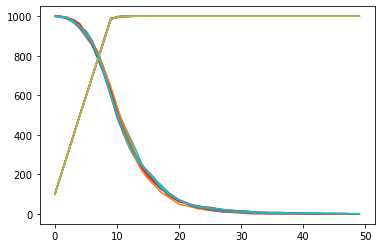

In [10]:
for i in range(10):
    sim = Simulator(Genome(1),i)
    sim.simulate(50)
    sim.plot()
# plt.legend()
plt.show()

1000
0
0


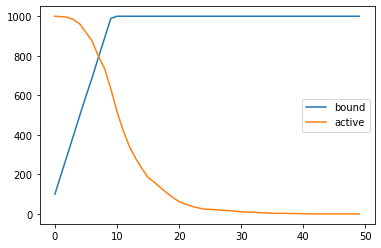

In [11]:
sim = Simulator(Genome(1),1)
sim.simulate(50)
sim.plot()
print(sim.n_bound[-1])
print(sim.n_active[-1])
print(sum(sim.unbound))
plt.legend()
plt.show()

In [12]:
sim.extruders[1]

1000
0
0


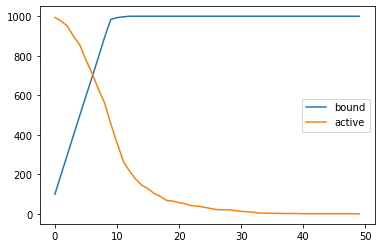

2000
0
0


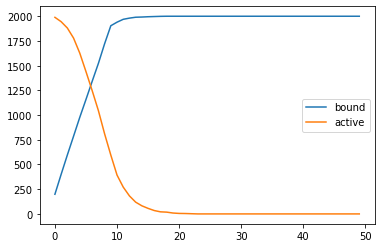

3000
0
0


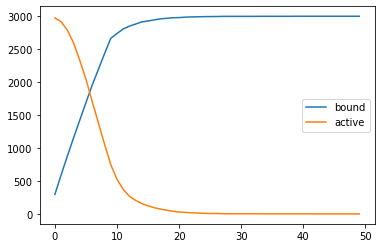

3963
39
37


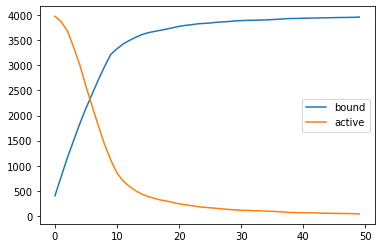

4379
621
621


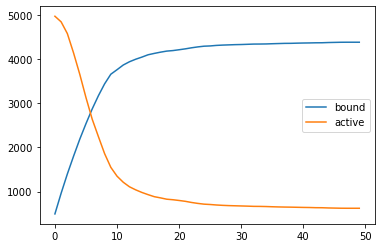

4391
1609
1609


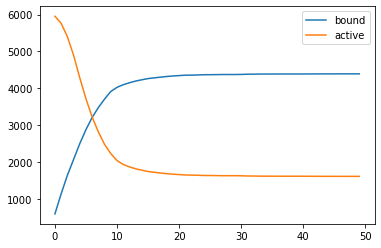

4411
2589
2589


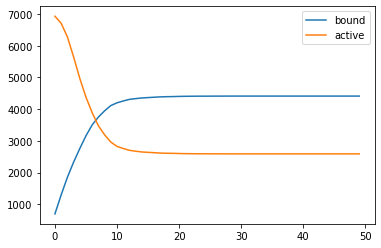

4387
3613
3613


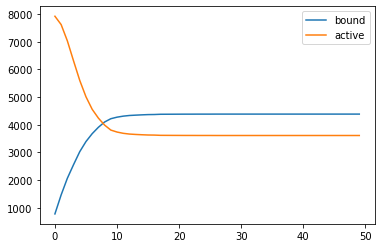

4387
4613
4613


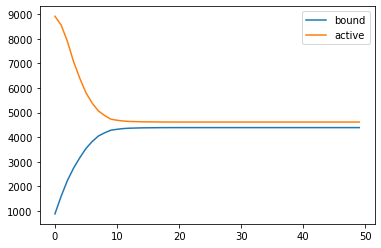

4403
5597
5597


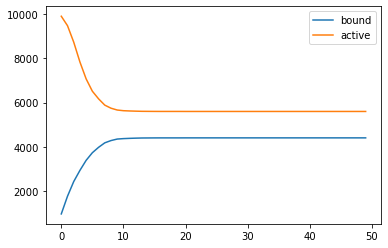

In [13]:
for i in range(1,11):    
    sim = Simulator(Genome(1),1, n_extruders=i*1000, option="both")
    sim.simulate(50)
    sim.plot()
    print(sim.n_bound[-1])
    print(sim.n_active[-1])
    print(sum(sim.unbound))
    plt.legend()
    plt.show()

100
8
0


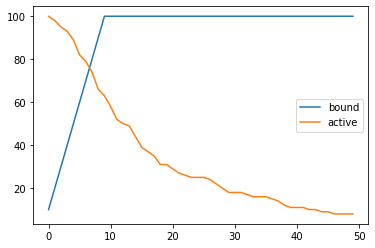

In [14]:
np.random.seed(27)
sim = Simulator(Genome(1),1, n_extruders=100, option="both")
sim.simulate(50)
sim.plot()
print(sim.n_bound[-1])
print(sim.n_active[-1])
print(sum(sim.unbound))
plt.legend()
plt.show()

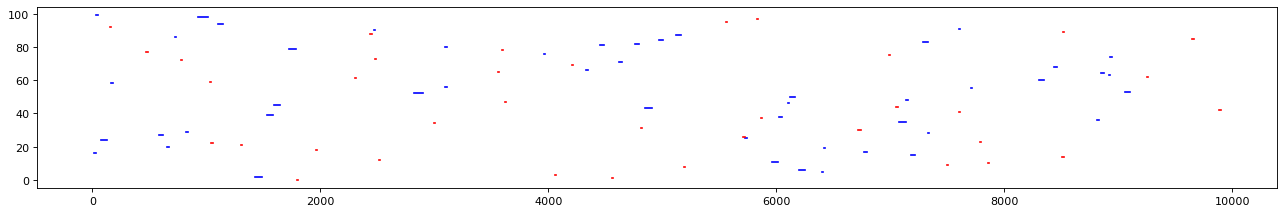

In [15]:
plt.figure(figsize=(20, 3), dpi=80)
sim.plot_fold()

100
21
0


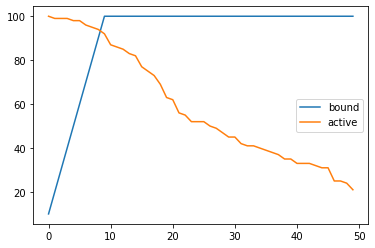

In [16]:
np.random.seed(27)
sim = Simulator(Genome(1),1, n_extruders=100, option="both_0.2")
sim.simulate(50)
sim.plot()
print(sim.n_bound[-1])
print(sim.n_active[-1])
print(sum(sim.unbound))
plt.legend()
plt.show()

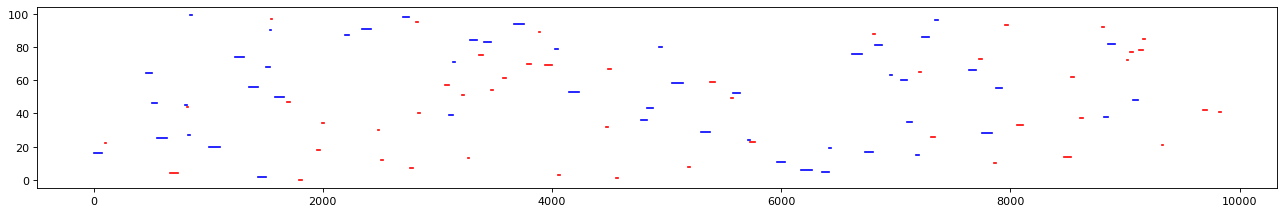

In [17]:
plt.figure(figsize=(20, 3), dpi=80)
sim.plot_fold()

1
0
0


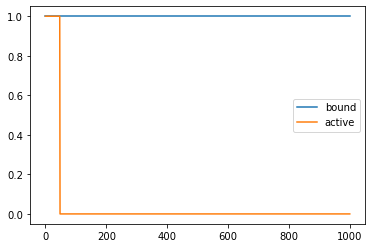

In [18]:
np.random.seed(27)
sim = Simulator(Genome(1),1, n_extruders=1, per_i=1)
sim.simulate(1000)
sim.plot()
print(sim.n_bound[-1])
print(sim.n_active[-1])
print(sum(sim.unbound))
plt.legend()
plt.show()

In [19]:
np.where(sim.genome.occupited)

(array([186, 284]),)

In [20]:
sim.genome.array[186:285]

array([1, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0,
       2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 0, 2, 2,
       2, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0,
       0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1])

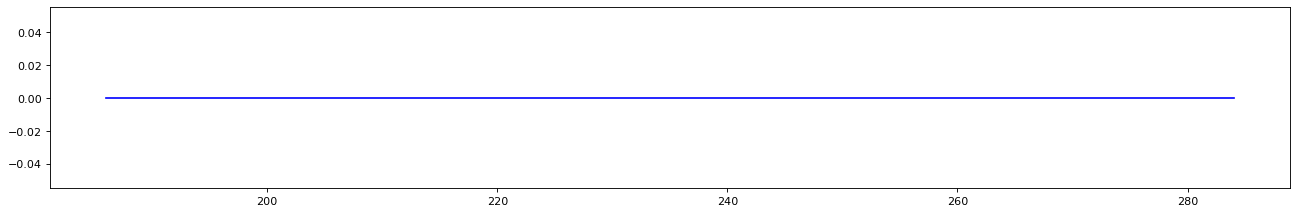

In [21]:
plt.figure(figsize=(20, 3), dpi=80)
sim.plot_fold()

In [22]:
sim.extruders[0].right

False

In [23]:
sim.extruders[0].left

False

2
0
0


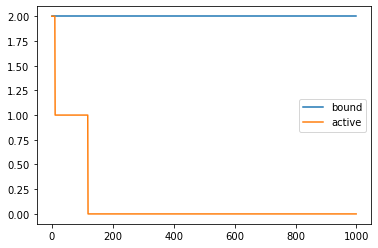

In [24]:
np.random.seed(27)
sim = Simulator(Genome(1),1, n_extruders=2, per_i=1, option="both_0.2")
sim.simulate(1000)
sim.plot()
print(sim.n_bound[-1])
print(sim.n_active[-1])
print(sum(sim.unbound))
plt.legend()
plt.show()

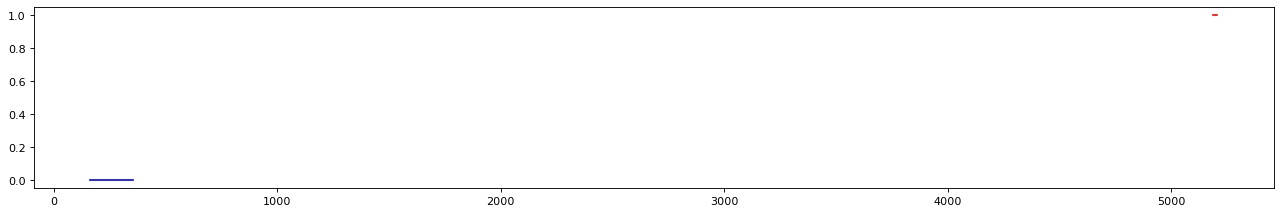

In [25]:
plt.figure(figsize=(20, 3), dpi=80)
sim.plot_fold()

In [26]:
np.where(sim.genome.occupited)

(array([ 162,  356, 5185, 5205]),)

In [27]:
sim.genome.array[162:357]

array([1, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2,
       0, 0, 1, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2,
       0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 0,
       2, 2, 2, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0,
       0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1, 2, 0, 2, 0, 2, 2, 0, 0, 0,
       0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 1, 0,
       2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2,
       0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2, 0, 2, 0, 0, 0, 1])

In [28]:
sim.genome.array[5185:5206]

array([2, 1, 2, 2, 1, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2])